# Some Neural Network Problems #

## Problem 1 ##

Consider the cell below, which selects a uniform random sample of outputs of the function $f(x,y) = x^2 - y^2$ on the region $[-1,1]x[-1,1]$. 

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

tempX = np.random.uniform(-1,1,2000)
tempY = np.random.uniform(-1,1,2000)

myX = np.array([tempX, tempY]).T

myX[:5]

def myfunc(X):
    
    return X[:,0]**2  - X[:,1]**2

myy = myfunc(myX)

1. Produce a 3D scatter plot of the data to confirm that that $f(x,y)$ has a 'saddle point' graph.

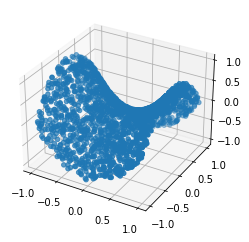

In [129]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(myX[:,0], myX[:,1], myy)

2. Jupyter class notes for Wednesday's class are available on the [github page](https://github.com/aleahy-work/CS-STAT323-W24/tree/main/CNotes).  In them I attempt to train a two-layer model with a [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) activation function and the [ADAM optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).  The training doesn't seem to succeed, with MSE not showing a consistent declining trend.  Modify the hyperparameters of the model until you produce a model that has MSE tending to zero over 100 epochs. You should try modifying the following hyperparameters as needed:

   + Batch size
   + The number of layers
   + The number of nodes in a given layer

The last two will require changes to the Model class. You could also potentially experiment with optimizers, loss functions, and activation functions.

**Warning:** Every time you modify your Model class you have to reinitialize your model instance.  If you change your batch size, you have to reinitialize your Dataloader.

In [130]:
myXtensor = torch.from_numpy(myX)

In [131]:
myytensor = torch.from_numpy(myy)
# myytensor = myytensor.to(torch.float32)

In [132]:
train_ds = torch.utils.data.TensorDataset(myXtensor, myytensor)

In [133]:
batch_size = 20

In [134]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)

In [135]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        return x
    
input_size = 2
hidden_size = 32
output_size = 1
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.0001

loss_fn = nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [136]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = torch.squeeze(model(x_batch.float()))
        loss = loss_fn(pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        #is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        #accuracy_hist[epoch] += is_correct.sum()
    
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    # print('Epoch ', epoch, ' with loss ', loss_hist[epoch])
    print('Epoch ', epoch, ' with loss ', loss.item())


Epoch  0  with loss  0.17190316319465637
Epoch  1  with loss  0.10920592397451401
Epoch  2  with loss  0.11348281055688858
Epoch  3  with loss  0.18589667975902557
Epoch  4  with loss  0.18583889305591583
Epoch  5  with loss  0.10680902004241943
Epoch  6  with loss  0.1554582715034485
Epoch  7  with loss  0.1398015320301056
Epoch  8  with loss  0.14294612407684326
Epoch  9  with loss  0.08842494338750839
Epoch  10  with loss  0.09234936535358429
Epoch  11  with loss  0.043954864144325256
Epoch  12  with loss  0.027051880955696106
Epoch  13  with loss  0.0327497161924839
Epoch  14  with loss  0.01941612735390663
Epoch  15  with loss  0.017866553738713264
Epoch  16  with loss  0.02033599093556404
Epoch  17  with loss  0.006391567178070545
Epoch  18  with loss  0.008042337372899055
Epoch  19  with loss  0.005617981776595116
Epoch  20  with loss  0.007472722325474024
Epoch  21  with loss  0.006240938790142536
Epoch  22  with loss  0.004091481678187847
Epoch  23  with loss  0.00730041693896

3. In my training function done in class, I gave a quick "loss.item()" MSE measure at the end of each epoch.  The book's method uses loss_hist[epoch]/len(train_dl.dataset) instead.  (See below, and note that loss_fn is [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).)  Explain the difference between the two.  (This [discussion](https://discuss.pytorch.org/t/what-is-loss-item/61218/3) may be helpful.) **Then** produce a plot of loss_hist for all epochs. 

In [146]:
# loss.item() gives us the loss value for the last batch processed in each epoch.
#On the other hand, the book's method calculates the average loss across all batches so far in 
#an epoch using loss_hist[epoch]/len(train_dl.dataset).

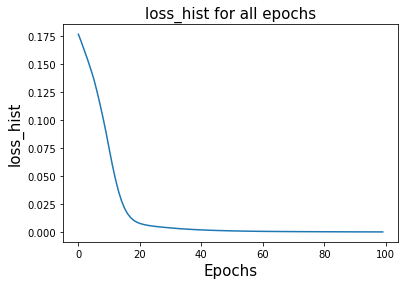

In [147]:
plt.plot(loss_hist)
plt.title('loss_hist for all epochs', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('loss_hist', size=15)
plt.show()

4. Remember that training data is not a good estimate of model success, since neural networks tend to [overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) the training data.

   + Ordinarily you would have to set aside some of the data for testing purposes, but *because of the way the data was generated* that won't be necessary.  Explain what I mean by this. Then generate a testing dataset 1/4 of the size of the training data, feed the features from this through the .forward() method of your model and use your loss function to find MSE for the testing data.  How does it compare to the MSE for your training data after 100 epochs?

#### the data generated is random and uniform and hence it is different values at a regular intervals between set limits. Because of this we don't need the test data. If the data was taken from real worl, we might have to test it.

# Why are you retraining down below????

In [158]:
tempX = np.random.uniform(-1,1,500)
tempY = np.random.uniform(-1,1,500)

testX = np.array([tempX, tempY]).T

def myfunc(X):
    
    return X[:,0]**2  - X[:,1]**2

testY = myfunc(testX)

In [159]:
myXtensor = torch.from_numpy(testX)

In [160]:
myytensor = torch.from_numpy(testY)
# myytensor = myytensor.to(torch.float32)

In [161]:
train_ds = torch.utils.data.TensorDataset(myXtensor, myytensor)

In [162]:
batch_size = 20

In [163]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)

In [164]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        return x
    
input_size = 2
hidden_size = 32
output_size = 1
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.0001

loss_fn = nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [165]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = torch.squeeze(model(x_batch.float()))
        loss = loss_fn(pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        #is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        #accuracy_hist[epoch] += is_correct.sum()
    
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    # print('Epoch ', epoch, ' with loss ', loss_hist[epoch])
    print('Epoch ', epoch, ' with loss ', loss.item())


Epoch  0  with loss  0.16126254200935364
Epoch  1  with loss  0.17368890345096588
Epoch  2  with loss  0.19317138195037842
Epoch  3  with loss  0.18159440159797668
Epoch  4  with loss  0.11938563734292984
Epoch  5  with loss  0.16320167481899261
Epoch  6  with loss  0.06880173087120056
Epoch  7  with loss  0.16937854886054993
Epoch  8  with loss  0.1910097301006317
Epoch  9  with loss  0.0791163370013237
Epoch  10  with loss  0.13534702360630035
Epoch  11  with loss  0.12014941871166229
Epoch  12  with loss  0.15572305023670197
Epoch  13  with loss  0.24483147263526917
Epoch  14  with loss  0.11615202575922012
Epoch  15  with loss  0.09428007900714874
Epoch  16  with loss  0.12687644362449646
Epoch  17  with loss  0.11641504615545273
Epoch  18  with loss  0.15323951840400696
Epoch  19  with loss  0.16699868440628052
Epoch  20  with loss  0.11926815658807755
Epoch  21  with loss  0.102072574198246
Epoch  22  with loss  0.12780041992664337
Epoch  23  with loss  0.12613120675086975
Epoch 

# because of the smaller data size the MSE of test data, the MSE at 99th epoch is significantly less than that of train data set

You could also use the SKLearn [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) to compute MSE for your testing data.  Does it work?  If it doesn't, figure out how to fix it, and compare with the answer to your previous part. 

In [167]:
from sklearn.metrics import mean_squared_error

In [173]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        return x
    
input_size = 2
hidden_size = 32
output_size = 1
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.0001

loss_fn = nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [175]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = torch.squeeze(model(x_batch.float()))
        pred1 = pred.detach().numpy()
        y_batch1 = y_batch.float().detach().numpy()
        loss1 = mean_squared_error(pred1, y_batch1)
        loss = mean_squared_error(pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        #is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        #accuracy_hist[epoch] += is_correct.sum()
    
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    # print('Epoch ', epoch, ' with loss ', loss_hist[epoch])
    print('Epoch ', epoch, ' with loss ', loss.item())


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## Problem 2 ##

Consider the function $f(x,y)$ on the region $[-1,1]\times [-1,1]$ which has value 1 in the I and III quadrant and value -1 in the II and IV quadrant.  A sample from this function is given below.   This function is discussed on apges 419-430 of the textbok and in the ch13_part1.ipynb Jupyter notebook located [at the author's github page](https://github.com/rasbt/machine-learning-book/blob/main/ch13/ch13_part1.ipynb), where he solves this problem using slightly more advanced techniques (though it still may be helpful to read).  Your task is to use this data to find a neural network which fits this function with a categorical output.  Note that:

+ You will need to use the [binary classification loss function](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
+  Given my implementation of the function, it might be advisable to use the [hyperbolic tangent function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) instead of the sigmoid function in the final layer.  Why?
+  The key measure of success is accuracy
+  The model should require several layers and some consideration of activation functions

You should:

1. Implement a model which outputs training accuracy at the end of each epoch.  Then test your model by generating a test dataset and testing its accuracy.

In [199]:
tempX = np.random.uniform(-1,1,250)
tempY = np.random.uniform(-1,1,250)
mynewX = np.array([tempX, tempY]).T
myy = np.ones(250)
myy[((tempX < 0) & (tempY > 0)) | ((tempX > 0) & (tempY < 0))] = 0

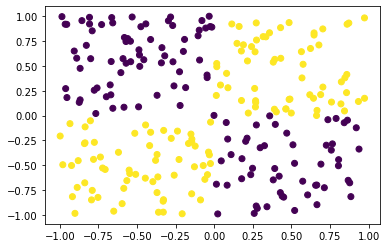

In [200]:
import matplotlib.pyplot as plt
plt.scatter(tempX, tempY, c= myy)
plt.show()

In [213]:
x_train = torch.tensor(mynewX, dtype=torch.float32)
y_train = torch.tensor(myy, dtype=torch.float32)

In [214]:
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [215]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [216]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [219]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= 250/batch_size
        accuracy_hist_train[epoch] /= 250/batch_size

        
    return loss_hist_train, accuracy_hist_train

history = train(model, num_epochs, train_dl)

In [220]:
history[1]

[tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6160),
 tensor(0.6200),
 tensor(0.6160),
 tensor(0.6160

In [221]:
# Testing Dataset

In [239]:
tempX = np.random.uniform(-1,1,100)
tempY = np.random.uniform(-1,1,100)
mynewX = np.array([tempX, tempY]).T
myy = np.ones(100)
myy[((tempX < 0) & (tempY > 0)) | ((tempX > 0) & (tempY < 0))] = 0

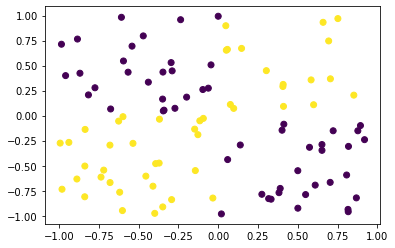

In [240]:
import matplotlib.pyplot as plt
plt.scatter(tempX, tempY, c= myy)
plt.show()

In [241]:
x_train = torch.tensor(mynewX, dtype=torch.float32)
y_train = torch.tensor(myy, dtype=torch.float32)

In [242]:
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [243]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [244]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [245]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= 100/batch_size
        accuracy_hist_train[epoch] /= 100/batch_size
        print("accuracy_hist_train " , epoch , " - ", accuracy_hist_train[epoch] )

train(model, num_epochs, train_dl)

accuracy_hist_train  0  -  tensor(0.3300)
accuracy_hist_train  1  -  tensor(0.3300)
accuracy_hist_train  2  -  tensor(0.3200)
accuracy_hist_train  3  -  tensor(0.3200)
accuracy_hist_train  4  -  tensor(0.3200)
accuracy_hist_train  5  -  tensor(0.3200)
accuracy_hist_train  6  -  tensor(0.3200)
accuracy_hist_train  7  -  tensor(0.3300)
accuracy_hist_train  8  -  tensor(0.3300)
accuracy_hist_train  9  -  tensor(0.3300)
accuracy_hist_train  10  -  tensor(0.3300)
accuracy_hist_train  11  -  tensor(0.3300)
accuracy_hist_train  12  -  tensor(0.3300)
accuracy_hist_train  13  -  tensor(0.3300)
accuracy_hist_train  14  -  tensor(0.3300)
accuracy_hist_train  15  -  tensor(0.3300)
accuracy_hist_train  16  -  tensor(0.3300)
accuracy_hist_train  17  -  tensor(0.3200)
accuracy_hist_train  18  -  tensor(0.3300)
accuracy_hist_train  19  -  tensor(0.3200)
accuracy_hist_train  20  -  tensor(0.3200)
accuracy_hist_train  21  -  tensor(0.3200)
accuracy_hist_train  22  -  tensor(0.3200)
accuracy_hist_train  

# because of the small size of the training dataset the improvment in accuracy is significant than the train dataset, I think the model overfits the test data

2. Once you are satisfied with the performance of your model, you should mprove on your model by generating a validation set and outputing both training and validation accuracy at each epoch.  
   

In [254]:
tempX = np.random.uniform(-1,1,250)
tempY = np.random.uniform(-1,1,250)
mynewX = np.array([tempX, tempY]).T
myy = np.ones(250)
myy[((tempX < 0) & (tempY > 0)) | ((tempX > 0) & (tempY < 0))] = 0

In [255]:
n_train = 125
x_train = torch.tensor(mynewX[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(myy[:n_train], dtype=torch.float32)
x_valid = torch.tensor(mynewX[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(myy[n_train:], dtype=torch.float32)

In [256]:
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [257]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [258]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [259]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
        print(epoch , " acc_train -", accuracy_hist_train[epoch], "acc_valid -", accuracy_hist_valid[epoch])

train(model, num_epochs, train_dl, x_valid, y_valid)

0  acc_train - tensor(0.2800) acc_valid - tensor(0.3440)
1  acc_train - tensor(0.2800) acc_valid - tensor(0.3440)
2  acc_train - tensor(0.2880) acc_valid - tensor(0.3440)
3  acc_train - tensor(0.2800) acc_valid - tensor(0.3440)
4  acc_train - tensor(0.2800) acc_valid - tensor(0.3440)
5  acc_train - tensor(0.2960) acc_valid - tensor(0.3440)
6  acc_train - tensor(0.2880) acc_valid - tensor(0.3440)
7  acc_train - tensor(0.2880) acc_valid - tensor(0.3440)
8  acc_train - tensor(0.2880) acc_valid - tensor(0.3440)
9  acc_train - tensor(0.2800) acc_valid - tensor(0.3440)
10  acc_train - tensor(0.2880) acc_valid - tensor(0.3440)
11  acc_train - tensor(0.2800) acc_valid - tensor(0.3520)
12  acc_train - tensor(0.2800) acc_valid - tensor(0.3520)
13  acc_train - tensor(0.2800) acc_valid - tensor(0.3600)
14  acc_train - tensor(0.2880) acc_valid - tensor(0.3680)
15  acc_train - tensor(0.2800) acc_valid - tensor(0.3680)
16  acc_train - tensor(0.2800) acc_valid - tensor(0.3760)
17  acc_train - tensor(0